In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

font = {'family': 'sans-serif', 'serif' : 'Helvetica',
        'size'   : 25}
plt.rc('font', **font)

In [2]:
import os
storage = os.environ['MICOM_EXP'] + 'setA_mono_simTime144h/' # on Peregrine
storage

run_status_file = storage + "run_status.tsv"
run_status = pd.read_csv(run_status_file, sep="\t")

rep_simID_dict = run_status.loc[run_status['program_log_doneSim']==1, ['rep_name', 'simID']].groupby('rep_name')['simID'].apply(list).to_dict()
rep_simID_dict

rep_name_list = list(rep_simID_dict.keys())
rep_name_list

media = ['EU_avg', 'DACH', 'diabetes2', 
         'gluten_free', 'high_fat', 'high_fiber', 
         'high_protein', 'mediterranean', 'unhealthy', 
         'vegan', 'vegetarian']

replicates = rep_name_list

replicate = 'rep1'
speciesID='setA_6'
simID = 'setA_6_plastic'
normalize = True
max_time = ['final', 12.0]

In [3]:
def metaprod_normalization(row):
    production_denominator = row[row >= 0].sum()
    consumption_denominator = row[row < 0].sum()
    
    normalized = []
    for r in row:
        if r >= 0.0:
            n = r/production_denominator if (production_denominator != 0.0) else r
        else:
            n = r/consumption_denominator*(-1) if (consumption_denominator != 0.0) else r
        normalized.append(n)
    return normalized

In [4]:
culture_type_list = ['batch', 'continuous']

metaprod_dyn = pd.DataFrame()

i=-1
for cult in culture_type_list:
    i+=1
    for m in media:
        data_dir = storage + replicate + '/v2.10.0_sim_' + simID + '/experiments/' + cult + '_mono-culture/'  + m + '/'
        data_file = data_dir + 'species_metabolite_production.tsv'

        data_df = pd.read_csv(data_file, sep="\t").drop('species_name', axis=1).iloc[:, :-1]

        if max_time is not None:
            data_df = data_df.loc[data_df['time'] <= max_time[i]] if max_time[i] != 'final' else data_df

        if normalize:
            normalized = data_df.iloc[:, 1:].apply(metaprod_normalization, axis=1)
            normalized_df = pd.DataFrame(normalized.to_list())
            normalized_df.columns = data_df.iloc[:, 1:].columns
            normalized_df['time'] = data_df['time']

            normalized_df['media'] = m
            normalized_df['culture_type'] = cult

            metaprod_dyn = pd.concat([metaprod_dyn, normalized_df])

        else:
            data_df['media'] = m
            data_df['culture_type'] = cult

            metaprod_dyn = pd.concat([metaprod_dyn, data_df])

# Remove metabolites with zero production/consumption
metaprod_dyn = metaprod_dyn.loc[:, metaprod_dyn.sum()!=0.0]

metaprod_dyn.reset_index(drop=True)    

metabolites = list(metaprod_dyn.drop(['time', 'media', 'culture_type'], axis=1).columns)

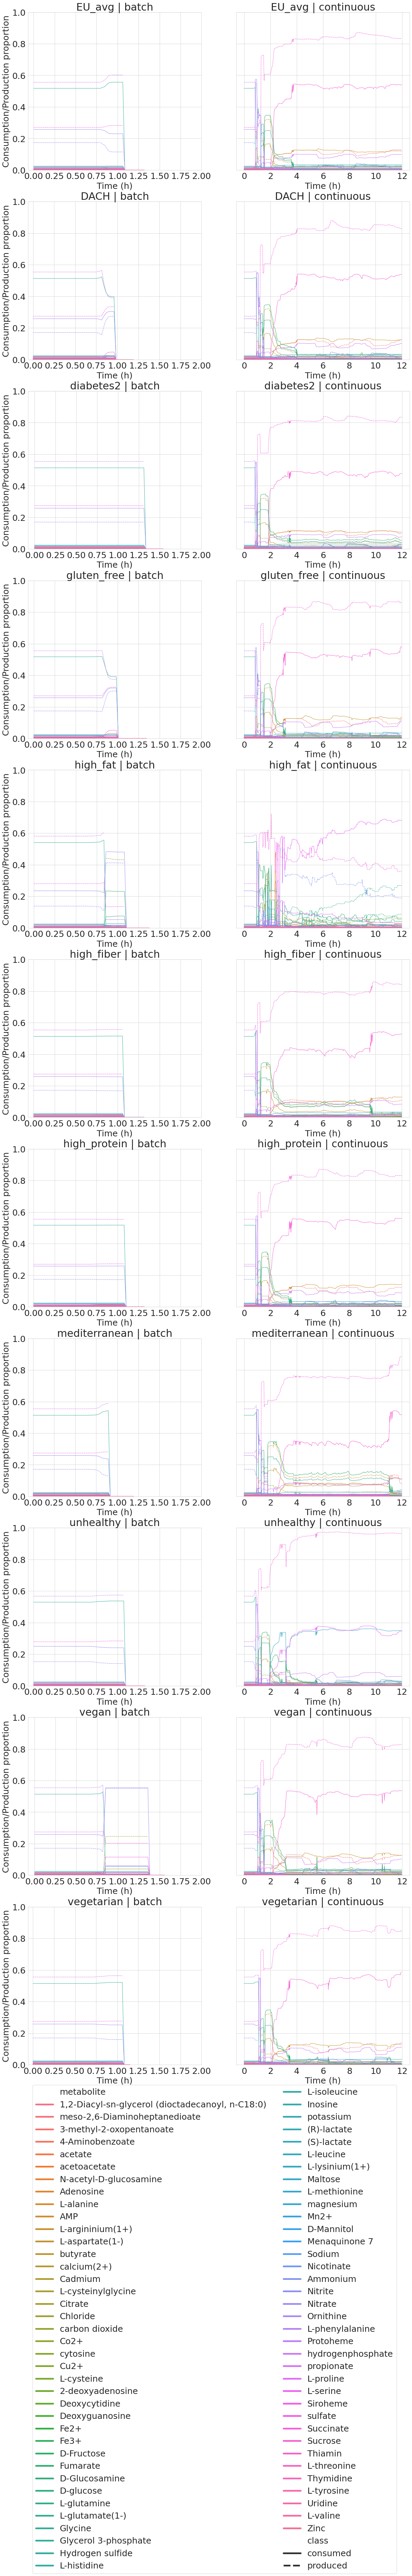

In [5]:
fig, ax = plt.subplots(ncols=2, nrows=len(media), sharex=False, sharey=True, figsize=(20, len(media)*10.05))

# Plot for each media
for i in range(len(media)):
    
    selected_metaprod_dyn = metaprod_dyn.loc[metaprod_dyn['media'] == media[i], :]
    
    for j in range(len(culture_type_list)):
        
        plot_data = selected_metaprod_dyn.loc[selected_metaprod_dyn['culture_type'] == culture_type_list[j], :]
        plot_data = pd.melt(plot_data, id_vars='time', value_vars=metabolites, var_name='metabolite', value_name='proportion')
        plot_data['class'] = plot_data['proportion'].apply(lambda x: 'produced' if x>0.0 else 'consumed')
        plot_data['proportion'] = plot_data['proportion'].abs()
        
        plot_max_time = plot_data['time'].max()
        if plot_max_time < 2.0:
            plot_xticks = np.arange(0.0, 2.25, 0.25)
        elif plot_max_time <= 6.0:
            plot_xticks = np.arange(0.0, 7.0, 1.0)
        else:
            plot_xticks = np.arange(0.0, plot_max_time+2.0, 2.0)
            
        kwargs={'linewidth':1}
            
        if (i < (len(media)-1)) | (j == 1):
            g = sns.lineplot(data=plot_data, x='time', y='proportion', hue='metabolite', style='class', ax=ax[i, j], legend=False, **kwargs)
        else:
            g = sns.lineplot(data=plot_data, x='time', y='proportion', hue='metabolite', style='class', ax=ax[i, j], legend='auto', **kwargs)
            legnd = ax[i,j].legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), ncol=2)
            # Change width of lines in legend
            for line in legnd.get_lines():
                line.set_linewidth(5)
            
        g.set(xticks=plot_xticks, ylim=(0.0, 1.0), 
              title = media[i] + ' | ' + culture_type_list[j], 
              xlabel='Time (h)', ylabel='Consumption/Production proportion')